In [ ]:
import pandas as pd
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, f1_score, make_scorer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, StandardScaler

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

from xgboost import XGBClassifier

from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [ ]:
X_train = pd.read_pickle('data/X_train.pkl')
y_train = pd.read_pickle('data/y_train.pkl')

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [ ]:
# Colonnes
categorical_cols = X_train.select_dtypes(include='object').columns
numeric_cols = X_train.select_dtypes(include='number').columns

# Préprocessing
preprocessor = ColumnTransformer([
    ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), categorical_cols),
    ('num', StandardScaler(), numeric_cols)
])

# Pipeline avec placeholder pour le classifieur
model = Pipeline([
    ('preprocess', preprocessor),
    ('classifier', RandomForestClassifier())  # placeholder
])

# Grille avec plusieurs modèles et paramètres spécifiques
param_grid = [
    {
        'classifier': [RandomForestClassifier(random_state=42)],
        'classifier__n_estimators': [100, 200],
        'classifier__max_depth': [None, 20],
        'classifier__min_samples_split': [2, 5],
        'classifier__min_samples_leaf': [1, 2]
    },
    {
        'classifier': [AdaBoostClassifier(random_state=42)],
        'classifier__n_estimators': [50, 100],
        'classifier__learning_rate': [0.5, 1.0]
    },
    {
        'classifier': [KNeighborsClassifier()],
        'classifier__n_neighbors': [5, 10],
        'classifier__weights': ['uniform', 'distance']
    },
    {
        'classifier': [XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)],
        'classifier__n_estimators': [100, 200],
        'classifier__max_depth': [3, 6],
        'classifier__learning_rate': [0.1, 0.3]
    }
]

# Scorer
f1_scorer = make_scorer(f1_score, pos_label='Yes')

# GridSearchCV
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring=f1_scorer,
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

print("Meilleur modèle :", best_model)
print("Meilleurs paramètres :", grid_search.best_params_)


In [84]:
# Extract F1 scores for each estimator from GridSearchCV results
results = grid_search.cv_results_
estimators = param_grid
f1_scores = []

for i, estimator in enumerate(estimators):
    mean_f1 = results['mean_test_score'][i]
    f1_scores.append((str(estimator['classifier'][0]), mean_f1))

# Display the F1 scores for each estimator
for estimator_name, f1_score_value in f1_scores:
    print(f"Estimator: {estimator_name}, F1 Score: {f1_score_value}")

Estimator: RandomForestClassifier(random_state=42), F1 Score: 0.4152591857857512
Estimator: AdaBoostClassifier(random_state=42), F1 Score: 0.3745915347622163
Estimator: KNeighborsClassifier(), F1 Score: 0.3839351888012358
Estimator: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tre

In [86]:
print(grid_search.best_params_)

{'classifier': RandomForestClassifier(random_state=42), 'classifier__max_depth': None, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}


In [88]:
categorical_cols = X_train.select_dtypes(include='object').columns
numeric_cols = X_train.select_dtypes(include='number').columns
preprocessor = ColumnTransformer([
    ('cat', 
        Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
        ]), 
        categorical_cols),
    ('num', 
        Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ]), 
        numeric_cols)
])

model = ImbPipeline([
    ('preprocess', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100))
])

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, pos_label='Yes')

print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")

Accuracy: 0.9989047619047619
F1 Score: 0.46511627906976744


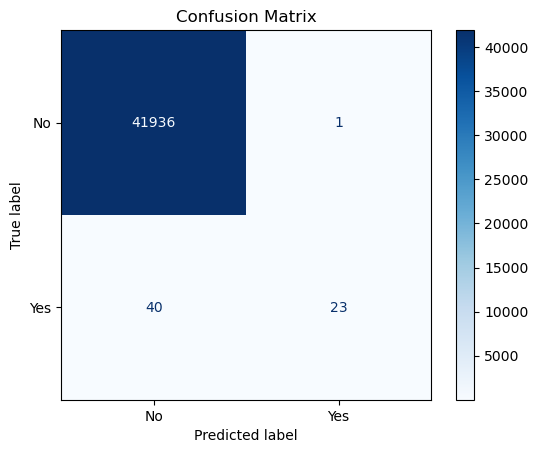

In [ ]:
ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['No', 'Yes']).plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

In [94]:
X_test = pd.read_pickle('data/X_test_2ain.pkl')
id = X_test['transaction_id']
X_test = X_test.drop(columns=['transaction_id'])
X_test.head()

,client_id_x,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,mcc,errors,...,hour,minute,second,expires month,expires year,acct_open_date year,acct_open_date month,acct_open_date day,acct_open_date hour,acct_open_date minute
0,900,3412,118.61,Swipe Transaction,61195,Panama City,FL,32401.0,5541,NaN,...,14,41,0,6,2019,2019,6,1,14,41
1,1741,3025,-204.00,Chip Transaction,49637,Tucson,AZ,85736.0,3509,NaN,...,13,45,0,3,2019,2019,3,21,13,45
2,1081,3892,-99.00,Chip Transaction,43293,Aurora,CO,80013.0,5499,NaN,...,11,53,0,4,2019,2019,4,19,11,53
3,1740,2382,28.44,Chip Transaction,26032,Mukwonago,WI,53149.0,7210,NaN,...,11,46,0,9,2019,2019,9,1,11,46
4,1207,6056,32.02,Online Transaction,39021,ONLINE,NaN,NaN,4784,NaN,...,21,24,0,6,2019,2019,6,6,21,24


In [95]:
X_test = pd.read_pickle('data/X_test.pkl')
y_pred = model.predict(X_test)
submission = pd.DataFrame({
    'id': id,
    'target': y_pred
})
submission.to_csv('submission.csv', index=False)